In [3]:
!pip install opencv-python

In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
import sys
import numpy as np
import pandas as pd
from tqdm import tqdm
pd.set_option("display.max_colwidth", -1)
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
from tqdm import tqdm

from tensorflow.keras import layers
from tensorflow.keras.layers import Input,Conv2D,MaxPool2D,Dropout,Concatenate, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import datetime
from PIL import Image, ImageStat
import math

%load_ext tensorboard

In [2]:
#seeding
seed = 2022
np.random.seed = seed
tf.seed = seed

In [ ]:
# !mkdir train test

In [ ]:
# print('Unzipping stage1_train.zip')
# !unzip -q "./Datasets/stage1_train.zip" -d train/
# print('Unzipped stage1_train.zip')

# print('Unzipping stage1_test.zip')
# !unzip -q "./Datasets/stage1_test.zip" -d test/
# print('Unzipped stage1_test.zip')

## Defining test and train Directories

In [3]:
TRAIN_ROOT_DIR = 'train'
TEST_ROOT_DIR = 'test'

In [4]:
# Function to create a dataframe of files which will be used for further processing
def files_df(root_dir):
    subdir = os.listdir(root_dir)
    files = []
    df = pd.DataFrame()
    for dir in subdir:
        files.append(os.path.join(root_dir,dir))
    df['files'] = files
    return df

In [5]:
train_df = files_df(TRAIN_ROOT_DIR)
test_df = files_df(TEST_ROOT_DIR)

In [6]:
train_df.head(2)

,files
0,train\00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552
1,train\003cee89357d9fe13516167fd67b609a164651b21934585648c740d2c3d86dc1


In [7]:
test_df.head(2)

,files
0,test\0114f484a16c152baa2d82fdd43740880a762c93f436c8988ac461c5c9dbe7d5
1,test\0999dab07b11bc85fb8464fc36c947fbd8b5d6ec49817361cb780659ca805eac


In [8]:
# Image parameters
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3
CLASSES = 3
BATCH_SIZE = 8

In [9]:
def image_df(filenames):
    image_paths = []
    mask_paths = []
    df = pd.DataFrame()
    for filename in tqdm(filenames):
        file_path = os.path.join(filename,'images')
        image_path = os.path.join(file_path,os.listdir(file_path)[0])
        image_paths.append(image_path)
        
        mask = np.zeros((IMG_WIDTH,IMG_HEIGHT,1))
        mask_dir = file_path.replace("images", "masks")
        masks = os.listdir(mask_dir)
        for m in masks:
            mask_path = os.path.join(mask_dir,m)
            mask_  = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)
            mask_  = cv2.resize(mask_,(IMG_WIDTH,IMG_HEIGHT),interpolation=cv2.INTER_NEAREST)
            mask_  = np.expand_dims(mask_, axis = -1)
            mask = np.maximum(mask,mask_)
        newmask_dir = mask_dir.replace("masks", "masks_")
        if not os.path.isdir(newmask_dir):
            os.mkdir(newmask_dir)
        newmask_path = image_path.replace("images", "masks_")
        mask_paths.append(newmask_path)
        cv2.imwrite(newmask_path, mask)
    df['images'] = image_paths
    df['masks'] = mask_paths
    return df

In [10]:
train_filenames = train_df['files']
train = image_df(train_filenames)

100%|██████████| 670/670 [00:43<00:00, 15.55it/s]


## Splitting train and test data

In [11]:
X_train, X_val = train_test_split(train, test_size=0.1, random_state=42)

In [12]:
X_train.head()

,images,masks
300,train\6f8197baf738986a1ec3b6ba92b567863d897a739376b7cec5599ad6cecafdfc\images\6f8197baf738986a1ec3b6ba92b567863d897a739376b7cec5599ad6cecafdfc.png,train\6f8197baf738986a1ec3b6ba92b567863d897a739376b7cec5599ad6cecafdfc\masks_\6f8197baf738986a1ec3b6ba92b567863d897a739376b7cec5599ad6cecafdfc.png
60,train\1740b0a67ca337ea31648b57c81bcfbb841c7bb5cad185199a9f4da596d531b9\images\1740b0a67ca337ea31648b57c81bcfbb841c7bb5cad185199a9f4da596d531b9.png,train\1740b0a67ca337ea31648b57c81bcfbb841c7bb5cad185199a9f4da596d531b9\masks_\1740b0a67ca337ea31648b57c81bcfbb841c7bb5cad185199a9f4da596d531b9.png
133,train\308084bdd358e0bd3dc7f2b409d6f34cc119bce30216f44667fc2be43ff31722\images\308084bdd358e0bd3dc7f2b409d6f34cc119bce30216f44667fc2be43ff31722.png,train\308084bdd358e0bd3dc7f2b409d6f34cc119bce30216f44667fc2be43ff31722\masks_\308084bdd358e0bd3dc7f2b409d6f34cc119bce30216f44667fc2be43ff31722.png
30,train\0b2e702f90aee4fff2bc6e4326308d50cf04701082e718d4f831c8959fbcda93\images\0b2e702f90aee4fff2bc6e4326308d50cf04701082e718d4f831c8959fbcda93.png,train\0b2e702f90aee4fff2bc6e4326308d50cf04701082e718d4f831c8959fbcda93\masks_\0b2e702f90aee4fff2bc6e4326308d50cf04701082e718d4f831c8959fbcda93.png
69,train\1b44d22643830cd4f23c9deadb0bd499fb392fb2cd9526d81547d93077d983df\images\1b44d22643830cd4f23c9deadb0bd499fb392fb2cd9526d81547d93077d983df.png,train\1b44d22643830cd4f23c9deadb0bd499fb392fb2cd9526d81547d93077d983df\masks_\1b44d22643830cd4f23c9deadb0bd499fb392fb2cd9526d81547d93077d983df.png


In [13]:
X_val.head()

,images,masks
361,train\8a65e41c630d85c0004ce1772ff66fbc87aca34cb165f695255b39343fcfc832\images\8a65e41c630d85c0004ce1772ff66fbc87aca34cb165f695255b39343fcfc832.png,train\8a65e41c630d85c0004ce1772ff66fbc87aca34cb165f695255b39343fcfc832\masks_\8a65e41c630d85c0004ce1772ff66fbc87aca34cb165f695255b39343fcfc832.png
158,train\3a3fee427e6ef7dfd0d82681e2bcee2d054f80287aea7dfa3fa4447666f929b9\images\3a3fee427e6ef7dfd0d82681e2bcee2d054f80287aea7dfa3fa4447666f929b9.png,train\3a3fee427e6ef7dfd0d82681e2bcee2d054f80287aea7dfa3fa4447666f929b9\masks_\3a3fee427e6ef7dfd0d82681e2bcee2d054f80287aea7dfa3fa4447666f929b9.png
480,train\b4d902d42c93dea77b541456f8d905f35eeb24fc3a5b0b15b5678d78e0aabe0c\images\b4d902d42c93dea77b541456f8d905f35eeb24fc3a5b0b15b5678d78e0aabe0c.png,train\b4d902d42c93dea77b541456f8d905f35eeb24fc3a5b0b15b5678d78e0aabe0c\masks_\b4d902d42c93dea77b541456f8d905f35eeb24fc3a5b0b15b5678d78e0aabe0c.png
640,train\f534b43bf37ff946a310a0f08315d76c3fb3394681cf523acef7c0682240072a\images\f534b43bf37ff946a310a0f08315d76c3fb3394681cf523acef7c0682240072a.png,train\f534b43bf37ff946a310a0f08315d76c3fb3394681cf523acef7c0682240072a\masks_\f534b43bf37ff946a310a0f08315d76c3fb3394681cf523acef7c0682240072a.png
275,train\62570c4ff1c5ab6d9d383aba9f25e604768520b4266afd40fdf4734a694c8bc3\images\62570c4ff1c5ab6d9d383aba9f25e604768520b4266afd40fdf4734a694c8bc3.png,train\62570c4ff1c5ab6d9d383aba9f25e604768520b4266afd40fdf4734a694c8bc3\masks_\62570c4ff1c5ab6d9d383aba9f25e604768520b4266afd40fdf4734a694c8bc3.png


# Preprocessing the data

In [14]:
# Function to parse image and mask file path and convert them into image and mask
def parse_function(image_path, mask_path):
    image_string = tf.io.read_file(image_path)
    image = tf.image.decode_png(image_string, channels=IMG_CHANNELS)#
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH]) # height x width
    
    mask_string = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask_string, channels=IMG_CHANNELS)#
    mask = tf.image.convert_image_dtype(mask, tf.float32)
    mask = tf.image.resize(mask, [IMG_HEIGHT, IMG_WIDTH])                      
    return image, mask

In [15]:
# Function to perform data augmentation
def train_preprocess(image, mask):
    a = tf.random.uniform(())
    if a<0.2:
        image = tf.image.random_flip_left_right(image)
        mask = tf.image.random_flip_left_right(mask)
    elif a<0.4:
        image = tf.image.random_brightness(image, max_delta=32.0 / 255.0)
        mask = tf.image.random_brightness(mask, max_delta=32.0 / 255.0)
    elif a<0.6:
        image = tf.image.random_saturation(image, lower=0.5, upper=1.5)
        mask = tf.image.random_saturation(mask, lower=0.5, upper=1.5)
    elif a<0.8:
        image = tf.image.random_flip_up_down(image)
        mask = tf.image.random_flip_up_down(mask)
    else:
        image = tf.image.random_hue(image, 0.2)
        mask = tf.image.random_hue(mask, 0.2)
    
    image = tf.clip_by_value(image, 0.0, 1.0)
    mask = tf.clip_by_value(mask, 0.0, 1.0)
    return image, mask

In [16]:
# Training dataset
train_ds = tf.data.Dataset.from_tensor_slices((X_train['images'], X_train['masks']))
train_ds = train_ds.shuffle(X_train.shape[0])
train_ds = train_ds.map(parse_function, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.map(train_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.batch(BATCH_SIZE)
train_ds = train_ds.prefetch(1)

print(train_ds)

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None))>


In [17]:
# Validation dataset
val_ds = tf.data.Dataset.from_tensor_slices((X_val['images'], X_val['masks']))
val_ds = val_ds.shuffle(X_val.shape[0])
val_ds = val_ds.map(parse_function, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.batch(BATCH_SIZE)
val_ds = val_ds.prefetch(1)

# Sample of Train and Validation datasets

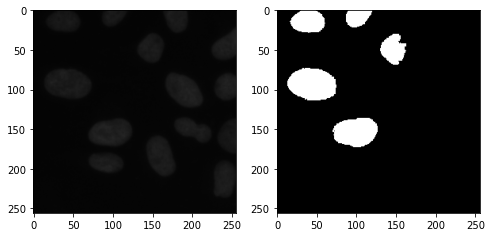

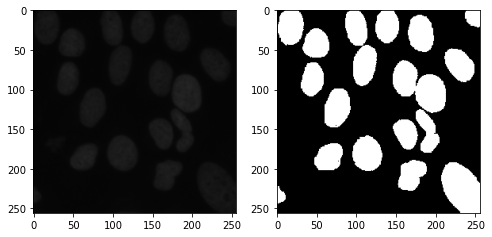

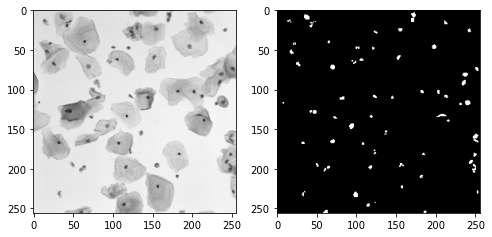

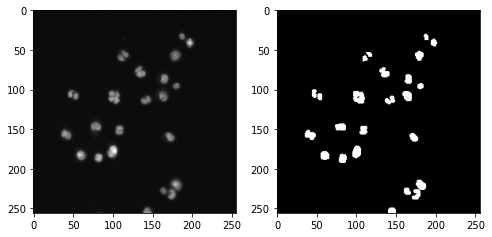

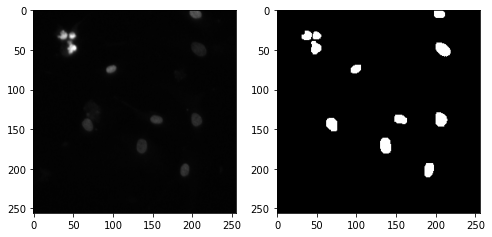

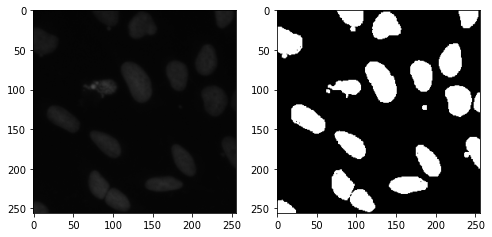

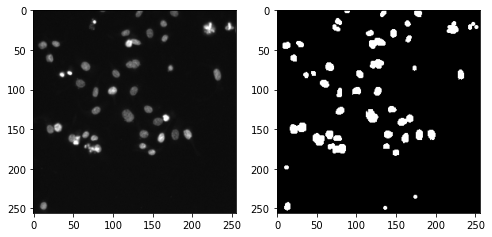

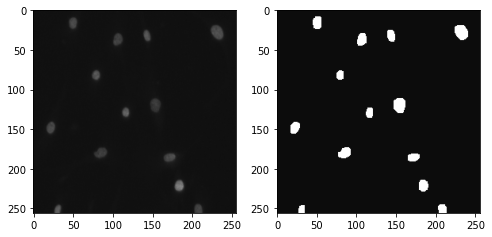

In [18]:
# Sample of training dataset
for image, mask in train_ds.take(1):
    for i in range(BATCH_SIZE):
        plt.figure(figsize=(8,4))
        plt.subplot(121)
        plt.imshow(image[i])
        plt.subplot(122)
        plt.imshow(mask[i], cmap = 'gray')
        plt.show()

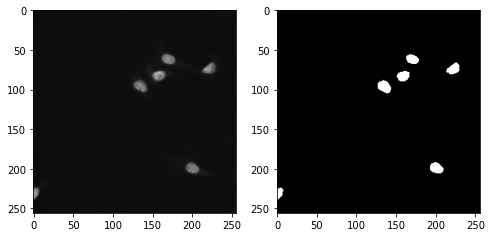

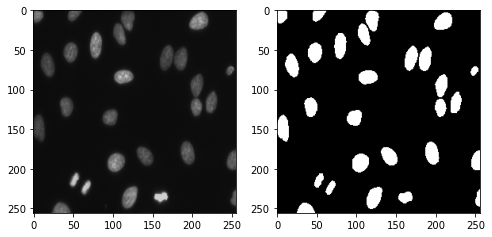

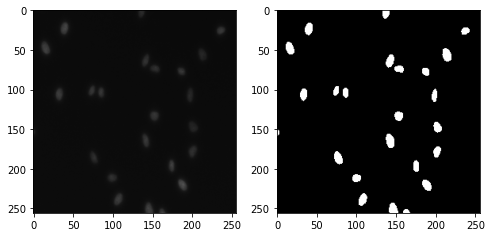

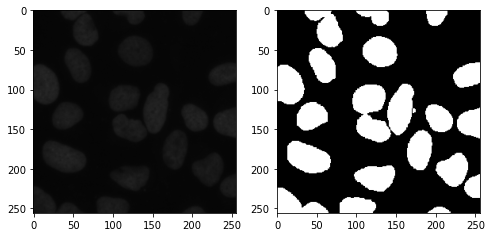

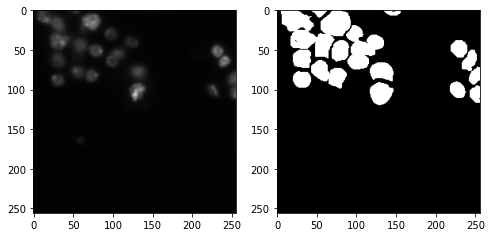

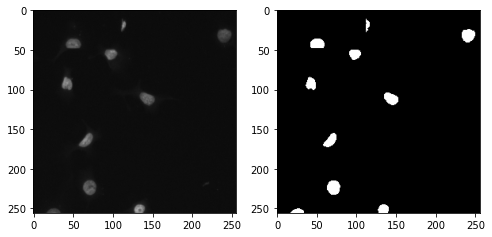

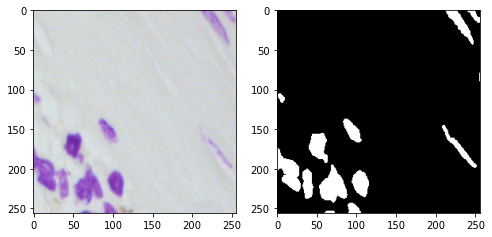

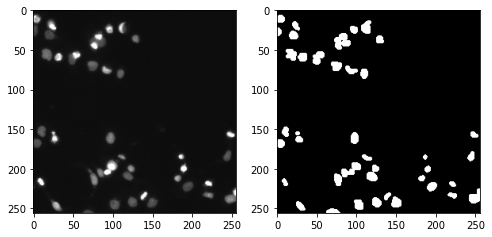

In [19]:
# Sample of validation dataset
for image, mask in val_ds.take(1):
    for i in range(BATCH_SIZE):
        plt.figure(figsize=(8,4))
        plt.subplot(121)
        plt.imshow(image[i])
        plt.subplot(122)
        plt.imshow(mask[i], cmap = 'gray')
        plt.show()

# Creating model

## UNet = Convolutional Networks for Biomedical Image Segmentation

In [20]:
# Custom MeanIoU Metric function
class MeanIoU(tf.keras.metrics.Metric):
    def __init__(self, num_classes, thres=0.5, name='mean_iou', dtype=None):
        super(MeanIoU, self).__init__(name=name, dtype=dtype)
        self.num_classes = num_classes
        self.thres = thres
        self.total_cm = self.add_weight('total_confusion_matrix',
                                        shape=(num_classes, num_classes),
                                        initializer=tf.zeros_initializer())

    def update_state(self, y_true, y_pred, sample_weight=None):
        
        y_true = tf.cast(y_true, self._dtype)
        y_pred = tf.cast(y_pred, self._dtype)
        if y_pred.shape.ndims > 1:
            y_pred = tf.reshape(y_pred, [-1])
        if y_true.shape.ndims > 1:
            y_true = tf.reshape(y_true, [-1])
        
        y_pred = tf.where(y_pred > self.thres, 1.0, 0.0)
        
        if sample_weight is not None:
            sample_weight = tf.cast(sample_weight, self._dtype)
            if sample_weight.shape.ndims > 1:
                sample_weight = tf.reshape(sample_weight, [-1])
        current_cm = tf.math.confusion_matrix(y_true,
                                              y_pred,
                                              self.num_classes,
                                              weights=sample_weight,
                                              dtype=self._dtype)
        
        return self.total_cm.assign_add(current_cm)
    def result(self):
        sum_over_row = tf.cast(tf.reduce_sum(self.total_cm, axis=0), dtype=self._dtype)
        sum_over_col = tf.cast(tf.reduce_sum(self.total_cm, axis=1), dtype=self._dtype)
        true_positives = tf.cast(tf.linalg.tensor_diag_part(self.total_cm), dtype=self._dtype)
        denominator = sum_over_row + sum_over_col - true_positives
        num_valid_entries = tf.reduce_sum(tf.cast(tf.math.not_equal(denominator, 0), dtype=self._dtype))
        iou = tf.math.divide_no_nan(true_positives, denominator)
        return tf.math.divide_no_nan(tf.reduce_sum(iou, name='mean_iou'), num_valid_entries)
    
    def reset_states(self):
        # The state of the metric will be reset at the start of each epoch.
        tf.keras.backend.set_value(self.total_cm, np.zeros((self.num_classes, self.num_classes)))
        
    def get_config(self):
        config = {'num_classes': self.num_classes}
        base_config = super(MeanIoU, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [21]:
mean_iou = MeanIoU(2, 0.4)

In [22]:
# Input Layer
# Input shape 256X256X3
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

# Left Side/Downsampling Side
# 256 -> 128
conv1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
conv1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv1)
pool1 = MaxPool2D((2, 2))(conv1)
pool1 = Dropout(0.25)(pool1)

# 128 -> 64
conv2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool1)
conv2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv2)
pool2 = MaxPool2D((2, 2))(conv2)
pool2 = Dropout(0.5)(pool2)

# 64 -> 32
conv3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool2)
conv3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv3)
pool3 = MaxPool2D((2, 2))(conv3)
pool3 = Dropout(0.5)(pool3)

# 32 -> 16
conv4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool3)
conv4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv4)
pool4 = MaxPool2D((2, 2))(conv4)
pool4 = Dropout(0.5)(pool4)

# Middle Part
# 16 -> 16
convm = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool4)
convm = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(convm)

# Right Side/ Upsampling Side
# 16 -> 32
uconv4 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(convm)
uconv4 = Concatenate()([uconv4, conv4])
uconv4 = Dropout(0.5)(uconv4)
uconv4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(uconv4)
uconv4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(uconv4)

# 32 -> 64
uconv3 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(uconv4)
uconv3 = Concatenate()([uconv3, conv3])
uconv3 = Dropout(0.5)(uconv3)
uconv3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(uconv3)
uconv3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(uconv3)

# 64 -> 128
uconv2 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(uconv3)
uconv2 = Concatenate()([uconv2, conv2])
uconv2 = Dropout(0.5)(uconv2)
uconv2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(uconv2)
uconv2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(uconv2)

# 128 -> 256
uconv1 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(uconv2)
uconv1 = Concatenate()([uconv1, conv1])
uconv1 = Dropout(0.5)(uconv1)
uconv1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(uconv1)
uconv1 = Conv2D(16, (3,1), activation='relu', kernel_initializer='he_normal', padding='same')(uconv1)

# Output Layer
# Output shape 256X256X1
outputs = Conv2D(CLASSES, (1, 1), activation='sigmoid')(uconv1)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou])#
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 16  2320        ['conv2d[0][0]']                 
                                )                                                             

                                                                                                  
 conv2d_15 (Conv2D)             (None, 128, 128, 32  9248        ['conv2d_14[0][0]']              
                                )                                                                 
                                                                                                  
 conv2d_transpose_3 (Conv2DTran  (None, 256, 256, 16  2064       ['conv2d_15[0][0]']              
 spose)                         )                                                                 
                                                                                                  
 concatenate_3 (Concatenate)    (None, 256, 256, 32  0           ['conv2d_transpose_3[0][0]',     
                                )                                 'conv2d_1[0][0]']               
                                                                                                  
 dropout_7

## Callback

In [23]:
model

In [24]:
!rm -rf ./model_save/

In [25]:
# Modelcheckpoint callback
if not os.path.exists('model_save'):
    os.makedirs('model_save')
filepath="model_save/weights-{epoch:04d}.hdf5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=filepath,
                                       save_best_only=True,
                                       mode='auto', 
                                       monitor='val_loss')

In [26]:
!rm -rf ./model/ 

In [27]:
# Tensorboard Callback
log_dir = os.path.join("model", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,
                                                      histogram_freq=1, 
                                                      write_graph=True)

# Model training

In [ ]:
# callbacks_list = [checkpoint, tensorboard_callback]
# history = model.fit(train_ds,
#                     initial_epoch = 0,
#                     epochs=30, 
#                     callbacks=callbacks_list, 
#                     validation_data=val_ds)

In [ ]:
# initial_epoch = int(sorted(os.listdir('model_save'))[-1].split('.')[0].split('-')[-1])
# history = model.fit(train_ds, 
#                     initial_epoch = initial_epoch,
#                     epochs=60, 
#                     callbacks=callbacks_list, 
#                     validation_data=val_ds)

In [28]:
model.load_weights("unet_model_15March.h5")

In [30]:
%tensorboard --logdir model1

## Inference

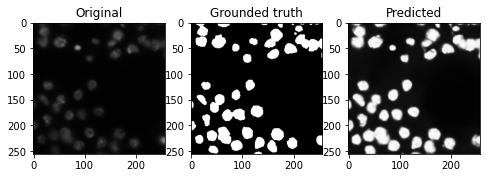

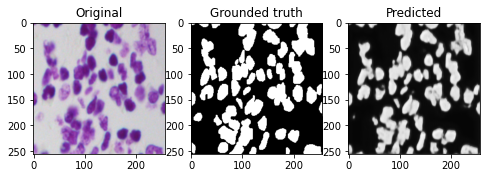

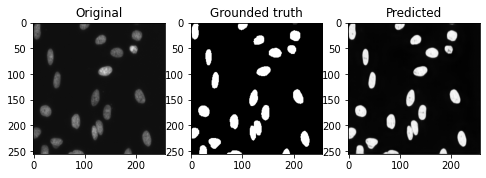

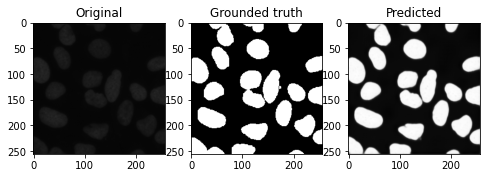

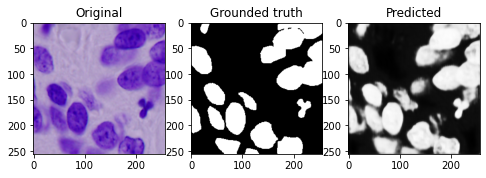

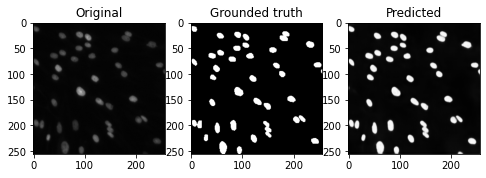

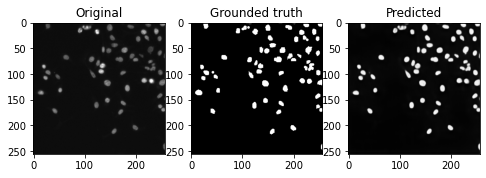

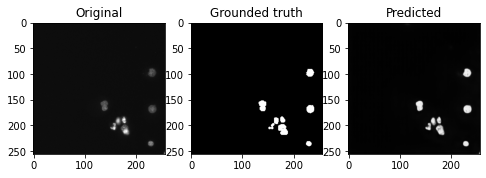

In [29]:
for image, mask in val_ds.take(1):
    for i in range(BATCH_SIZE):
        plt.figure(figsize=(8,4))
        ax1 = plt.subplot(131)
        plt.imshow(image[i])
        ax2=plt.subplot(132)
        plt.imshow(mask[i][:,:,0], cmap = 'gray')
        
        pred_mask  = model.predict(image[i][np.newaxis,:,:,:])
        ax3=plt.subplot(133)
        
        ax1.title.set_text('Original')
        ax2.title.set_text('Grounded truth')
        ax3.title.set_text('Predicted')
        plt.imshow(pred_mask[0,:,:,0], cmap = 'gray')
        plt.show()

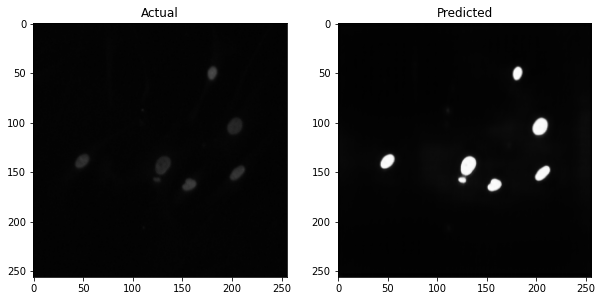

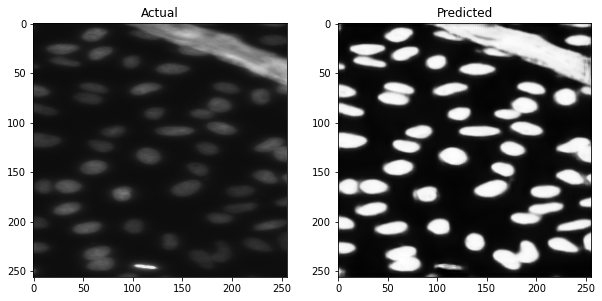

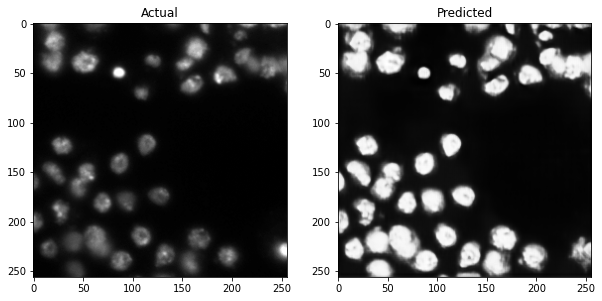

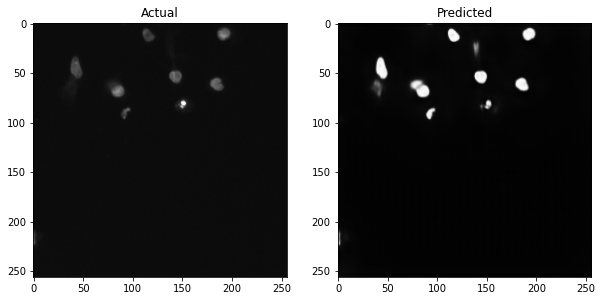

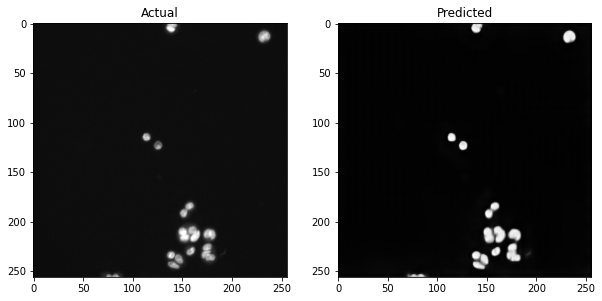

In [30]:
test_filenames = test_df['files']
for filename in test_filenames[:5]:
    file_path = os.path.join(filename,'images')
    image_path = os.path.join(file_path,os.listdir(file_path)[0])
    image_string = tf.io.read_file(image_path)
    image = tf.image.decode_png(image_string, channels=IMG_CHANNELS)#
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH]) # height x width
    
    pred_mask  = model.predict(image[np.newaxis,:,:,:])
    
    plt.figure(figsize=(10,6))
    ax1=plt.subplot(121)
    plt.imshow(image)
    ax2=plt.subplot(122)
    ax1.title.set_text('Actual')
    ax2.title.set_text('Predicted')
    plt.imshow(pred_mask[0,:,:,0], cmap='gray')
    plt.show()

## EDA

In [31]:
# Function to create a dataframe with iou_scores and image and mask paths.
def metric_df(data):
    iou_scores = []
    m = MeanIoU(2, 0.4)
    for i in range(len(data)):
        image_path = data['images'].iloc[i]
        mask_path = data['masks'].iloc[i]
        image_string = tf.io.read_file(image_path)
        image = tf.image.decode_png(image_string, channels=IMG_CHANNELS)#
        image = tf.image.convert_image_dtype(image, tf.float32)
        image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH]) # height x width
    
        mask_string = tf.io.read_file(mask_path)
        mask = tf.image.decode_png(mask_string, channels=CLASSES)#
        mask = tf.image.convert_image_dtype(mask, tf.float32)
        mask = tf.image.resize(mask, [IMG_HEIGHT, IMG_WIDTH])
        
        pred_mask = model.predict(image[np.newaxis,:,:,:])
        m.update_state(mask, pred_mask)
        iou_score = m.result().numpy()
        iou_scores.append(iou_score)
    data['iou_scores'] = iou_scores
    return data

In [32]:
df = X_train.copy()
df = metric_df(df)
df = df.sort_values('iou_scores')
df.head()

,images,masks,iou_scores
622,train\edd36ed822e7ed760ff73e0524df22aa5bf5c565efcdc6c39603239c0896e7a8\images\edd36ed822e7ed760ff73e0524df22aa5bf5c565efcdc6c39603239c0896e7a8.png,train\edd36ed822e7ed760ff73e0524df22aa5bf5c565efcdc6c39603239c0896e7a8\masks_\edd36ed822e7ed760ff73e0524df22aa5bf5c565efcdc6c39603239c0896e7a8.png,0.869897
666,train\feffce59a1a3eb0a6a05992bb7423c39c7d52865846da36d89e2a72c379e5398\images\feffce59a1a3eb0a6a05992bb7423c39c7d52865846da36d89e2a72c379e5398.png,train\feffce59a1a3eb0a6a05992bb7423c39c7d52865846da36d89e2a72c379e5398\masks_\feffce59a1a3eb0a6a05992bb7423c39c7d52865846da36d89e2a72c379e5398.png,0.870270
210,train\4dbbb275960ab9e4ec2c66c8d3000f7c70c8dce5112df591b95db84e25efa6e9\images\4dbbb275960ab9e4ec2c66c8d3000f7c70c8dce5112df591b95db84e25efa6e9.png,train\4dbbb275960ab9e4ec2c66c8d3000f7c70c8dce5112df591b95db84e25efa6e9\masks_\4dbbb275960ab9e4ec2c66c8d3000f7c70c8dce5112df591b95db84e25efa6e9.png,0.872304
176,train\4193474b2f1c72f735b13633b219d9cabdd43c21d9c2bb4dfc4809f104ba4c06\images\4193474b2f1c72f735b13633b219d9cabdd43c21d9c2bb4dfc4809f104ba4c06.png,train\4193474b2f1c72f735b13633b219d9cabdd43c21d9c2bb4dfc4809f104ba4c06\masks_\4193474b2f1c72f735b13633b219d9cabdd43c21d9c2bb4dfc4809f104ba4c06.png,0.873655
511,train\c0152b1a260e71f9823d17f4fbb4bf7020d5dce62b4a12b3099c1c8e52a1c43a\images\c0152b1a260e71f9823d17f4fbb4bf7020d5dce62b4a12b3099c1c8e52a1c43a.png,train\c0152b1a260e71f9823d17f4fbb4bf7020d5dce62b4a12b3099c1c8e52a1c43a\masks_\c0152b1a260e71f9823d17f4fbb4bf7020d5dce62b4a12b3099c1c8e52a1c43a.png,0.873666


In [33]:
df.tail()

,images,masks,iou_scores
70,train\1b518cd2ea84a389c267662840f3d902d0129fab27696215db2488de6d4316c5\images\1b518cd2ea84a389c267662840f3d902d0129fab27696215db2488de6d4316c5.png,train\1b518cd2ea84a389c267662840f3d902d0129fab27696215db2488de6d4316c5\masks_\1b518cd2ea84a389c267662840f3d902d0129fab27696215db2488de6d4316c5.png,0.924727
292,train\6b72b61b80060a9e79a4747f9c5d5af135af9db466681c2d1086f784c7130699\images\6b72b61b80060a9e79a4747f9c5d5af135af9db466681c2d1086f784c7130699.png,train\6b72b61b80060a9e79a4747f9c5d5af135af9db466681c2d1086f784c7130699\masks_\6b72b61b80060a9e79a4747f9c5d5af135af9db466681c2d1086f784c7130699.png,0.925037
30,train\0b2e702f90aee4fff2bc6e4326308d50cf04701082e718d4f831c8959fbcda93\images\0b2e702f90aee4fff2bc6e4326308d50cf04701082e718d4f831c8959fbcda93.png,train\0b2e702f90aee4fff2bc6e4326308d50cf04701082e718d4f831c8959fbcda93\masks_\0b2e702f90aee4fff2bc6e4326308d50cf04701082e718d4f831c8959fbcda93.png,0.927326
60,train\1740b0a67ca337ea31648b57c81bcfbb841c7bb5cad185199a9f4da596d531b9\images\1740b0a67ca337ea31648b57c81bcfbb841c7bb5cad185199a9f4da596d531b9.png,train\1740b0a67ca337ea31648b57c81bcfbb841c7bb5cad185199a9f4da596d531b9\masks_\1740b0a67ca337ea31648b57c81bcfbb841c7bb5cad185199a9f4da596d531b9.png,0.960217
300,train\6f8197baf738986a1ec3b6ba92b567863d897a739376b7cec5599ad6cecafdfc\images\6f8197baf738986a1ec3b6ba92b567863d897a739376b7cec5599ad6cecafdfc.png,train\6f8197baf738986a1ec3b6ba92b567863d897a739376b7cec5599ad6cecafdfc\masks_\6f8197baf738986a1ec3b6ba92b567863d897a739376b7cec5599ad6cecafdfc.png,0.961802


# Tail Output samples

In [ ]:
d1 = df.tail()
for i in range(5):
    image_path = d1['images'].iloc[i]
    mask_path = d1['masks'].iloc[i]
    image_string = tf.io.read_file(image_path)
    image = tf.image.decode_png(image_string, channels=IMG_CHANNELS)#
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH]) # height x width
    
    mask_string = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask_string, channels=CLASSES)#
    mask = tf.image.convert_image_dtype(mask, tf.float32)
    mask = tf.image.resize(mask, [IMG_HEIGHT, IMG_WIDTH])
    
    pred_mask  = model.predict(image[np.newaxis,:,:,:])
    
    plt.figure(figsize=(10,6))
    ax1=plt.subplot(131)
    plt.imshow(image)
    ax2=plt.subplot(132)
    plt.imshow(mask[:,:,0], cmap='gray')
    ax3=plt.subplot(133)
    plt.imshow(pred_mask[0,:,:,0], cmap='gray')
    ax1.title.set_test("Image")
    ax2.title.set_test("Grounded Truth")
    ax3.title.set_test("Predicted")

# Head output sample

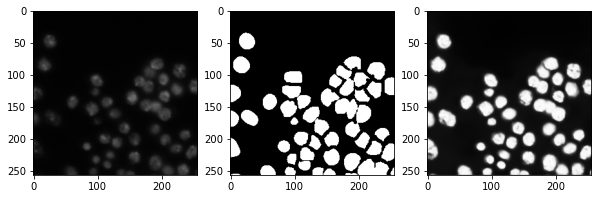

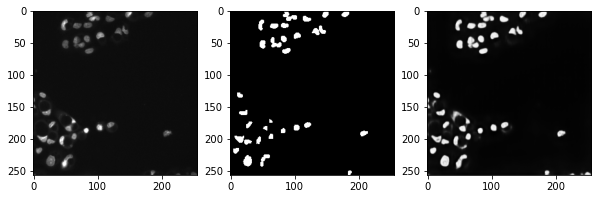

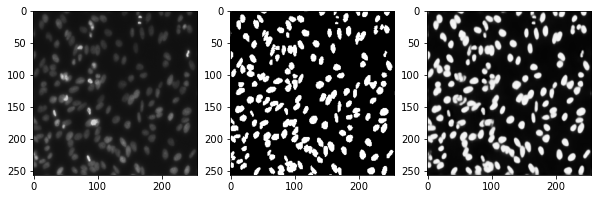

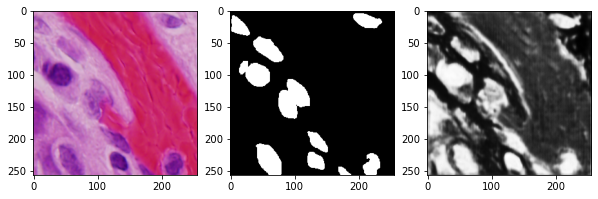

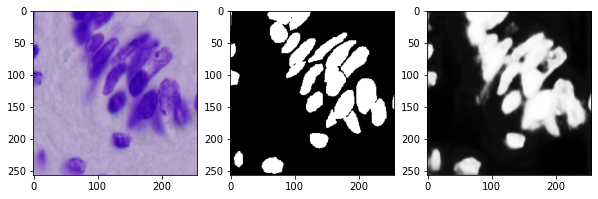

In [35]:
d2 = df.head()
for i in range(5):
    image_path = d2['images'].iloc[i]
    mask_path = d2['masks'].iloc[i]
    image_string = tf.io.read_file(image_path)
    image = tf.image.decode_png(image_string, channels=IMG_CHANNELS)#
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH]) # height x width
    
    mask_string = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask_string, channels=CLASSES)#
    mask = tf.image.convert_image_dtype(mask, tf.float32)
    mask = tf.image.resize(mask, [IMG_HEIGHT, IMG_WIDTH])
    
    pred_mask  = model.predict(image[np.newaxis,:,:,:])
    
    plt.figure(figsize=(10,6))
    plt.subplot(131)
    plt.imshow(image)
    plt.subplot(132)
    plt.imshow(mask[:,:,0], cmap='gray')
    plt.subplot(133)
    plt.imshow(pred_mask[0,:,:,0], cmap='gray')
    plt.show()

# Distribution of IoU Scores

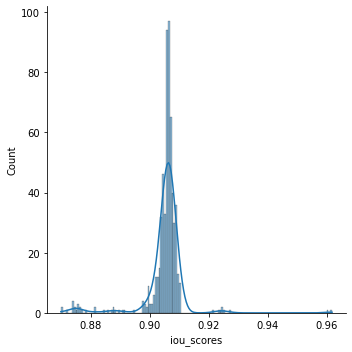

In [36]:
sns.displot(data=df, x="iou_scores", kde=True)

# Quantizing the model to deploy it on smaller devices

In [45]:
# Saving the model
# model.save("unet_24march.h5")

In [37]:
# UNet Model
unet_model = tf.keras.models.load_model("unet_24march.h5")

In [38]:
import pathlib

MyNewModel_24march


In [63]:
# tflite_models_dir = pathlib.Path("./MyNewModel_24march/")
# tflite_models_dir.mkdir(exist_ok=True, parents=True)

In [64]:
# # Post Training quantized UNet model
# converter = tf.lite.TFLiteConverter.from_keras_model(unet_model)
# converter.optimizations = [tf.lite.Optimize.DEFAULT]
# quant_unet_model = converter.convert()
# # Save the quantized UNet model:
# quant_unet_file = tflite_models_dir/"quant_unet_model.tflite"
# quant_unet_file.write_bytes(quant_unet_model)

INFO:tensorflow:Assets written to: C:\Users\nivid\AppData\Local\Temp\tmpzrbftsn1\assets


INFO:tensorflow:Assets written to: C:\Users\nivid\AppData\Local\Temp\tmpzrbftsn1\assets


1994304

In [39]:
# Lets compare the size of both the models
print("UNet model in Mb:", os.path.getsize("unet_24march.h5") / float(2**20))
print("Quantized UNet in Mb:", os.path.getsize("/MyNewModel_24march/quant_unet_model.tflite") / float(2**20))


UNet model in Mb: 7.517906188964844
Quantized UNet in Mb: 1.90191650390625


In [40]:
# Importing Quantized UNet model
u_interpreter = tf.lite.Interpreter(model_path="/MyNewModel_24march/quant_unet_model.tflite")
# Function to predict segments using quantized UNet model
def lite_unet_model(images):
  u_interpreter.allocate_tensors()
  u_interpreter.set_tensor(u_interpreter.get_input_details()[0]['index'], images)
  u_interpreter.invoke()
  return u_interpreter.get_tensor(u_interpreter.get_output_details()[0]['index'])

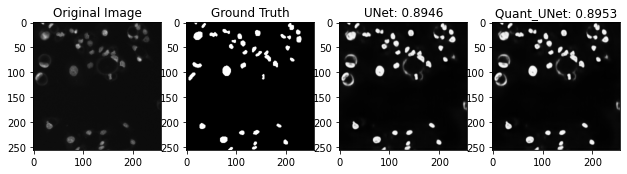

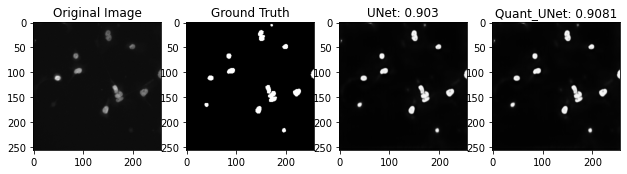

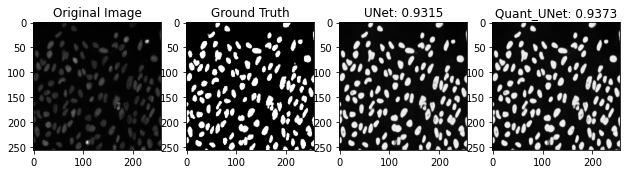

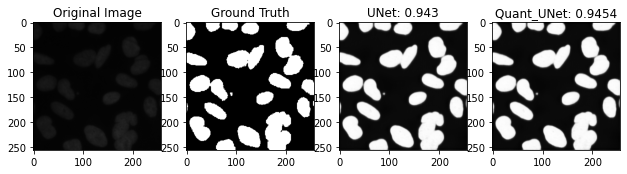

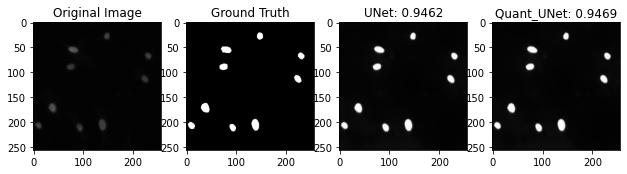

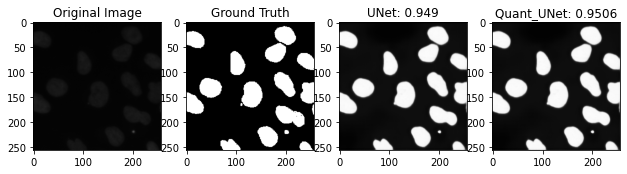

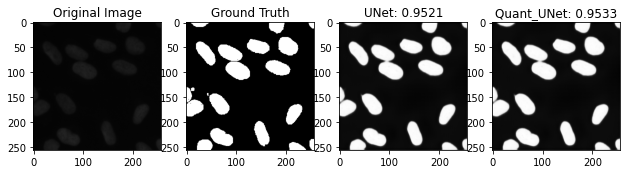

In [ ]:
# we can set the size of n for the number of images we want
df = train.sample(n=8, random_state=1)
m = MeanIoU(2, 0.4)
for i in range(len(df)):
    image_path = df['images'].iloc[i]
    mask_path = df['masks'].iloc[i]
    image_string = tf.io.read_file(image_path)
    image = tf.image.decode_png(image_string, channels=IMG_CHANNELS)#
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH]) # height x width
    
    mask_string = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask_string, channels=CLASSES)#
    mask = tf.image.convert_image_dtype(mask, tf.float32)
    mask = tf.image.resize(mask, [IMG_HEIGHT, IMG_WIDTH])

    pred_mask_u = unet_model.predict(image[np.newaxis,:,:,:])
    m.update_state(mask, pred_mask_u)
    u_iou_score = m.result().numpy()

    pred_mask_qu = lite_unet_model(image[np.newaxis,:,:,:])[0]
    m.update_state(mask, pred_mask_qu)
    qu_iou_score = m.result().numpy()


    fig = plt.figure(figsize=(16,14))

    ax1 = fig.add_subplot(161)
    ax1.title.set_text('Original Image')    
    ax1.imshow(image)

    ax2 = fig.add_subplot(162)
    ax2.title.set_text('Ground Truth')    
    ax2.imshow(mask[:,:,0], cmap='gray')

    ax3 = fig.add_subplot(163)
    ax3.title.set_text('UNet: '+ str(round(u_iou_score,4)))    
    ax3.imshow(pred_mask_u[0,:,:,0], cmap='gray')

    ax4 = fig.add_subplot(164)
    ax4.title.set_text('Quant_UNet: '+ str(round(qu_iou_score,4)))    
    ax4.imshow(pred_mask_qu[:,:,0], cmap='gray')
    
    plt.show()

# DO not come here :) 

In [ ]:
history

In [ ]:
model

In [ ]:
model.save('./.',save_format='h5')

In [ ]:
model.save_weights("unet_model_15March.h5")